In [8]:
# imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

In [4]:
# data import
df = pd.read_csv("amazon_data.csv")
df = df.drop(columns=["asin", "imgUrl", "productURL"],axis=1)
df

,title,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...
2222737,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2222738,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2222739,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2222740,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


## Preliminary checks

In [5]:
# null values
df.isnull().sum()

title                0
stars                0
reviews              0
price                0
isBestSeller         0
boughtInLastMonth    0
categoryName         0
dtype: int64

In [6]:
df["isBestSeller"].unique()

array([False,  True])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222742 entries, 0 to 2222741
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   title              object 
 1   stars              float64
 2   reviews            int64  
 3   price              float64
 4   isBestSeller       bool   
 5   boughtInLastMonth  int64  
 6   categoryName       object 
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 103.9+ MB


## Data Exploration
Here I look at all the numerical data to gain an understanding on the dataset. I find that from the 2+ million entries, most have 0 stars or reviews. This indicates the majority of products are just listings and do not get any sales.

From the price histogram, a clear right skew can be seen. This is the result of a few very high priced items that greatly deviate from the median. 

### Rating/Stars

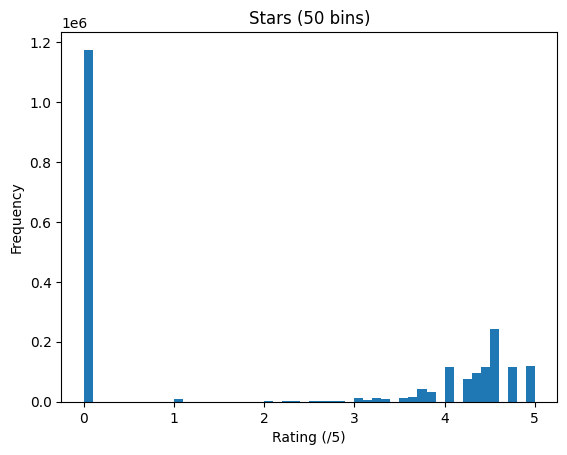

In [36]:
plt.hist(df['stars'], bins=50)

plt.title('Stars (50 bins)')
plt.xlabel("Rating (/5)")
plt.ylabel("Frequency")

# Save the histogram with a transparent background
plt.savefig("Figures\Ratings.png", transparent=True)

plt.show()

### No. reviews

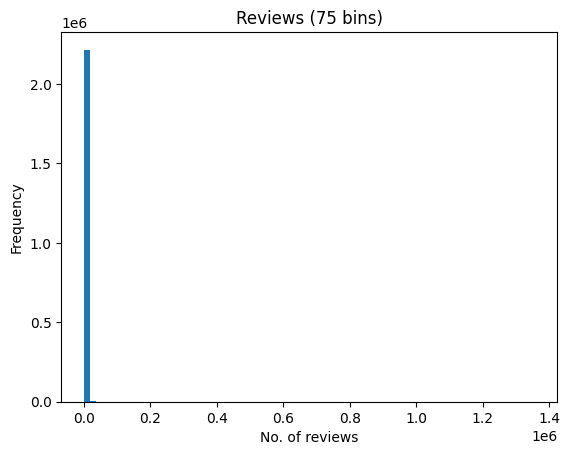

In [35]:
b = 75
plt.hist(df['reviews'], bins=b)

plt.title(f'Reviews ({b} bins)')
plt.xlabel("No. of reviews")
plt.ylabel("Frequency")

# Save the histogram with a transparent background
plt.savefig("Figures\Reviews.png", transparent=True)

plt.show()

### Prices

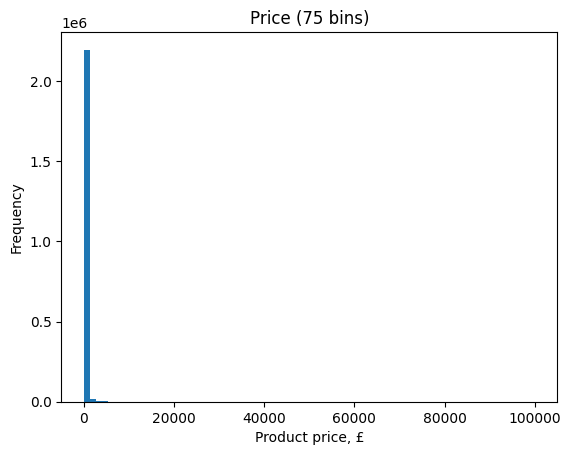

In [45]:
plt.hist(df['price'], bins=75)

plt.title('Price (75 bins)')
plt.xlabel("Product price, £")
plt.ylabel("Frequency")

# Save the histogram with a transparent background
plt.savefig(r"Figures\Price.png", transparent=True)

plt.show()

### Best seller status

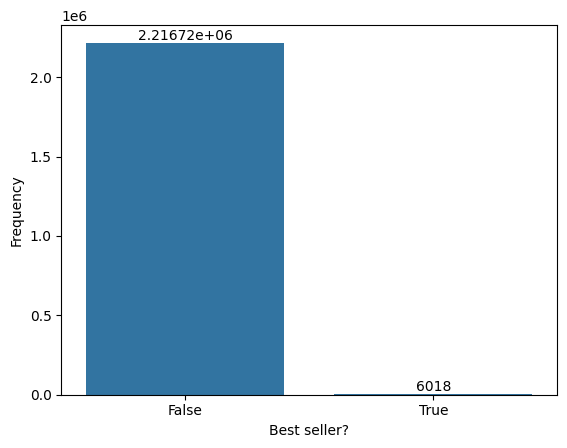

In [44]:
barplot = sns.countplot(x='isBestSeller', data=df)
for bar in barplot.containers:
    barplot.bar_label(bar)

ax = plt.gca()

ax.set_xlabel('Best seller?')
ax.set_ylabel('Frequency')
ax.tick_params(axis='both')

# Save the countplot with a transparent background
plt.savefig(r"Figures\isBestSeller.png", transparent=True)

# Display the countplot
plt.show()

### No. purchased in the last month

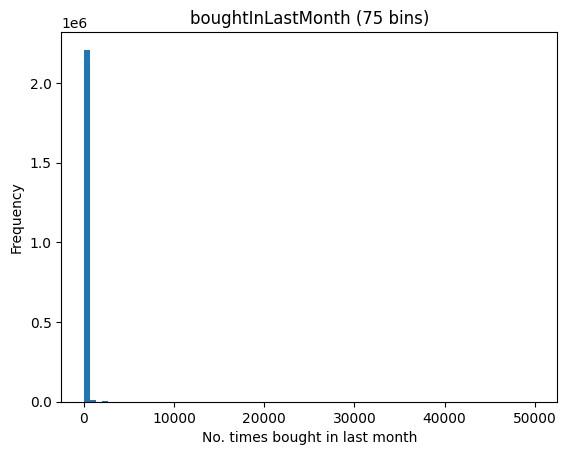

In [47]:
plt.hist(df['boughtInLastMonth'], bins=75)

plt.title('boughtInLastMonth (75 bins)')
plt.xlabel("No. times bought in last month")
plt.ylabel("Frequency")

# Save the histogram with a transparent background
plt.savefig(r"Figures\boughtInLastMonth.png", transparent=True)

plt.show()

## Pre-Processing
isBestSeller = bool

title = string
categoryName = string

In [6]:
df.describe()

,stars,reviews,price,boughtInLastMonth
count,2.222742e+06,2.222742e+06,2.222742e+06,2.222742e+06
mean,2.031870e+00,3.821617e+02,9.425737e+01,1.856902e+01
std,2.185497e+00,5.020752e+03,3.606225e+02,1.919030e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,1.000000e+01,0.000000e+00
50%,0.000000e+00,0.000000e+00,1.990000e+01,0.000000e+00
75%,4.400000e+00,4.400000e+01,4.771000e+01,0.000000e+00
max,5.000000e+00,1.356658e+06,1.000000e+05,5.000000e+04


In [7]:
df.categoryName.unique()

array(['Hi-Fi Speakers', 'CD, Disc & Tape Players', 'Wearable Technology',
       'Light Bulbs', 'Bathroom Lighting',
       'Heating, Cooling & Air Quality', 'Coffee & Espresso Machines',
       'Lab & Scientific Products', 'Smart Speakers',
       'Motorbike Clothing', 'Motorbike Accessories',
       'Motorbike Batteries', 'Motorbike Boots & Luggage',
       'Motorbike Chassis', 'Handmade Home & Kitchen Products',
       'Hardware', 'Storage & Home Organisation',
       'Fireplaces, Stoves & Accessories', 'PC Gaming Accessories',
       'USB Gadgets', 'Blank Media Cases & Wallets', 'Car & Motorbike',
       'Boys', 'Sports & Outdoors', 'Microphones', 'String Instruments',
       'Karaoke Equipment', 'PA & Stage',
       'General Music-Making Accessories', 'Wind Instruments',
       'Handmade Gifts', 'Fragrances', 'Calendars & Personal Organisers',
       'Furniture & Lighting', 'Computer Printers', 'Ski Goggles',
       'Snowboards', 'Skiing Poles', 'Downhill Ski Boots',
       'Hiki